# Análises e Teste dos Modelos

### Metodologia e Resultados Esperados

- **Modelagem Preditiva:**  
  Aplicação de algoritmos de Machine Learning (como Random Forest, XGBoost e LightGBM) para criar um modelo capaz de identificar e classificar medicamentos com risco elevado de efeitos adversos.

- **Análise Exploratória e Engenharia de Features:**  
  Refinamento dos dados por meio da análise estatística e da limitação dos valores únicos em variáveis categóricas, garantindo um modelo com maior robustez e interpretabilidade.

- **Visualização e Interatividade:**  
  Desenvolvimento de dashboards interativos que apresentam, de forma intuitiva, a distribuição dos riscos e as principais influências sobre as predições, facilitando uma análise detalhada dos medicamentos.

- **Resultados:**  
  Espera-se que o modelo consiga:
  - Prever com alta precisão os medicamentos de risco.
  - Oferecer uma visão clara dos fatores determinantes por meio de explicações locais e globais.
  - Servir de base para melhorias significativas na segurança e na eficiência dos processos de desenvolvimento e comercialização dos produtos farmacêuticos.


In [1]:
import pandas as pd
import numpy as np
from funcoes import *
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 16,6
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, RocCurveDisplay, roc_auc_score, ConfusionMatrixDisplay
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import shap
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from joblib import dump

C:\Users\roni_\anaconda3\envs\ambiente_streamlit\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-23 11:40:06.316 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [2]:
dados = pd.read_csv("medicamentos_ml.csv")
dados.head(10)

,use0,Chemical Class,Habit Forming,Therapeutic Class,Action Class,n_effects,dosage
0,Treatment of Bacterial infections,Macrolides,No,ANTI INFECTIVES,Macrolides,3,625
1,Treatment of Bacterial infections,Macrolides,No,ANTI INFECTIVES,Macrolides,4,500
2,Treatment of Cough with mucus,Phenylmethylamine Derivative,No,RESPIRATORY,Mucolytics,14,0
3,Treatment of Sneezing and runny nose due to al...,Diphenylmethane Derivative,No,RESPIRATORY,H1 Antihistaminics (second Generation),4,120
4,Treatment of Allergic conditions,Pyridines Derivatives,No,RESPIRATORY,H1 Antihistaminics (First Generation),2,25
5,Treatment of Sneezing and runny nose due to al...,Diphenylmethane Derivative,No,RESPIRATORY,H1 Antihistaminics (second Generation),8,0
6,Treatment of Bacterial infections,Macrolides,No,ANTI INFECTIVES,Macrolides,3,625
7,Treatment of Bacterial infections,Macrolides,No,ANTI INFECTIVES,Macrolides,4,500
8,Treatment of Anxiety,Piperazine Derivative,No,RESPIRATORY,H1 Antihistaminics (First Generation),5,25
9,Treatment of Dry cough,Diphenylmethane Derivative,No,RESPIRATORY,Cough suppressants,4,0


In [3]:
dados_enc = dados.copy()
dados_enc

,use0,Chemical Class,Habit Forming,Therapeutic Class,Action Class,n_effects,dosage
0,Treatment of Bacterial infections,Macrolides,No,ANTI INFECTIVES,Macrolides,3,625
1,Treatment of Bacterial infections,Macrolides,No,ANTI INFECTIVES,Macrolides,4,500
2,Treatment of Cough with mucus,Phenylmethylamine Derivative,No,RESPIRATORY,Mucolytics,14,0
3,Treatment of Sneezing and runny nose due to al...,Diphenylmethane Derivative,No,RESPIRATORY,H1 Antihistaminics (second Generation),4,120
4,Treatment of Allergic conditions,Pyridines Derivatives,No,RESPIRATORY,H1 Antihistaminics (First Generation),2,25
...,...,...,...,...,...,...,...
222820,Treatment of Bacterial infections,Broad Spectrum (Third & fourth generation ceph...,No,ANTI INFECTIVES,Cephalosporins: 3 generation,3,100
222821,Treatment of Hypertension (high blood pressure),Benzothiazepine derivative,No,CARDIAC,Calcium channel blockers- Nondihydropyridines,8,30
222822,Treatment of Anxiety,Piperazine Derivative,No,RESPIRATORY,H1 Antihistaminics (First Generation),5,25
222823,Treatment of Bacterial infections,Macrolides,No,ANTI INFECTIVES,Macrolides,5,500


In [4]:
for coluna in dados_enc.columns:
    if dados_enc[coluna].dtype=="object":
        dados_enc[coluna] = dados_enc[coluna].astype("category")
        dados_enc[coluna] = dados_enc[coluna].cat.codes

In [5]:
dados_enc.head()

,use0,Chemical Class,Habit Forming,Therapeutic Class,Action Class,n_effects,dosage
0,448,452,0,1,248,3,625
1,448,452,0,1,248,4,500
2,471,594,0,17,262,14,0
3,632,306,0,17,191,4,120
4,427,694,0,17,190,2,25


## Visualizações

**Não há grandes correlações entre as variáveis. A maior correlação existente é entre a classe terapêutica e a dosagem, porém o valor de 0.23 não é uma correlação tão significativa**

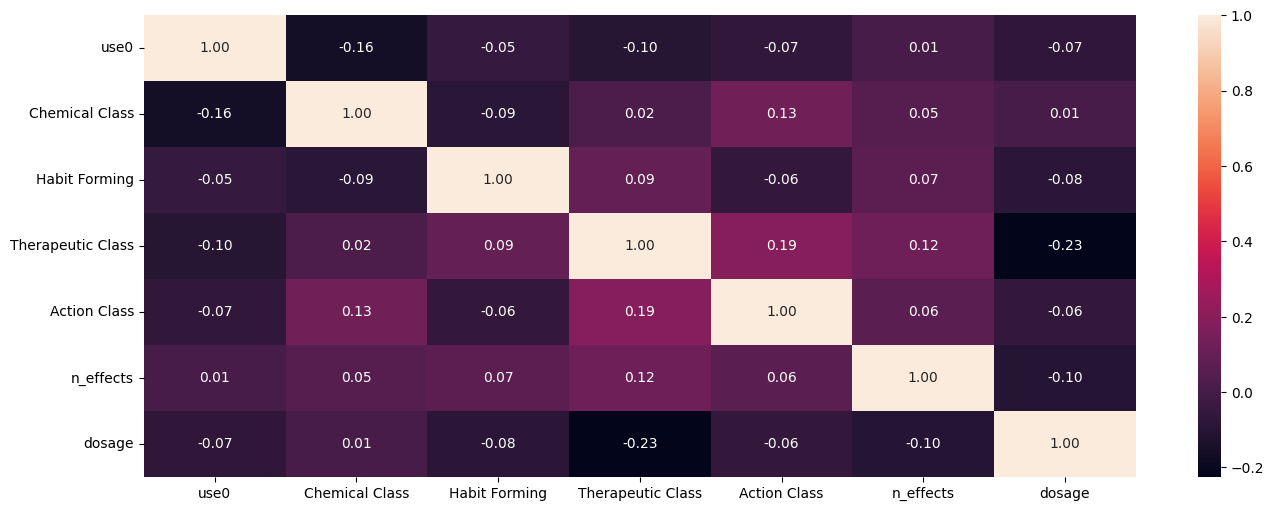

In [6]:
dados_corr = dados_enc.corr(method="kendall")
sns.heatmap(dados_corr, fmt=".2f", annot=True, robust=True)
plt.show()

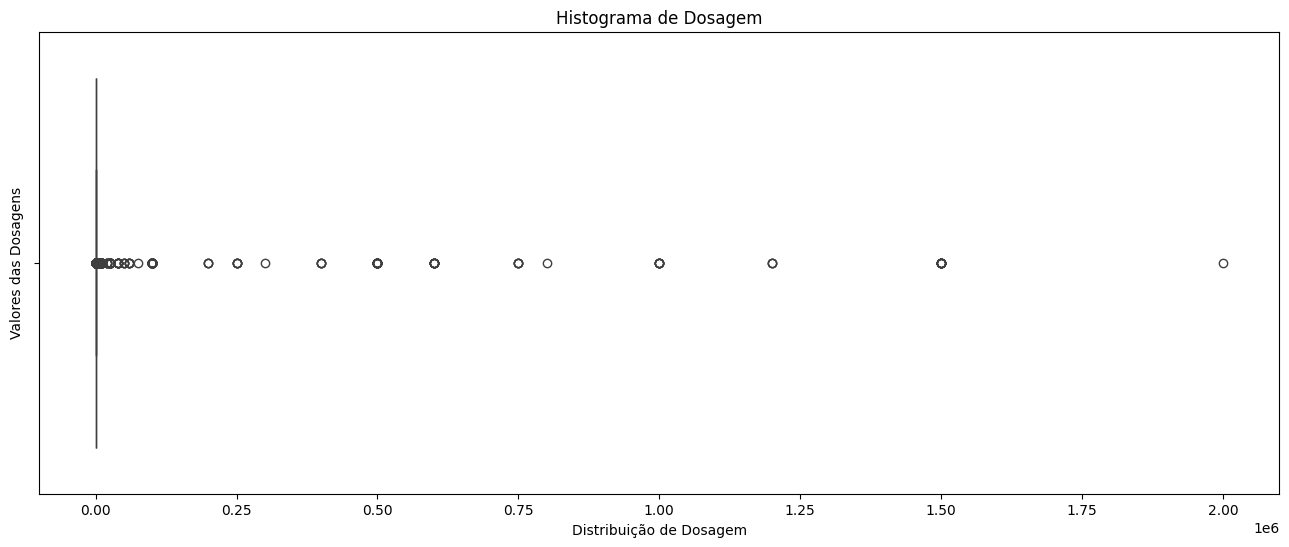

In [7]:
sns.boxplot(dados, x="dosage").set_title("Histograma de Dosagem")
plt.xlabel("Distribuição de Dosagem")
plt.ylabel("Valores das Dosagens")
plt.show()

In [8]:
dados.loc[dados["dosage"]>= 1000000]

,use0,Chemical Class,Habit Forming,Therapeutic Class,Action Class,n_effects,dosage
24394,Heart attack,"Amino acids, Peptides analogues",No,CARDIAC,First Generation Thrombolytics,4,1500000
25455,Treatment of Bacterial infections,Penicillins,No,ANTI INFECTIVES,Cell wall active agent - Narrow spectrum Penic...,3,1000000
25752,Treatment of Bacterial infections,Penicillins,No,ANTI INFECTIVES,Cell wall active agent - Narrow spectrum Penic...,3,1200000
28610,Treatment of Bacterial infections,Penicillins,No,ANTI INFECTIVES,Cell wall active agent - Narrow spectrum Penic...,3,1000000
29085,Treatment of Bacterial infections,Penicillins,No,ANTI INFECTIVES,Cell wall active agent - Narrow spectrum Penic...,3,2000000
29693,Treatment of Bacterial infections,Penicillins,No,ANTI INFECTIVES,Cell wall active agent - Narrow spectrum Penic...,3,1200000
31371,Heart attack,"Amino acids, Peptides analogues",No,CARDIAC,First Generation Thrombolytics,4,1500000
82669,Treatment of Bacterial infections,Penicillins,No,ANTI INFECTIVES,Cell wall active agent - Narrow spectrum Penic...,3,1000000
85840,Treatment of Bacterial infections,Penicillins,No,ANTI INFECTIVES,Cell wall active agent - Narrow spectrum Penic...,3,1000000
109495,Heart attack,"Amino acids, Peptides analogues",No,CARDIAC,First Generation Thrombolytics,4,1500000


- **A coluna dosagem possui alguns outliers, porém esses valores não irão passar por transformação**
- *Como é possível ver acima esses valores representam medicamentos específicos que possuem altas dosagens, como por exemplo:*
- > Penicilinas com alta dosagem e alguns tipos de vitaminas que também possuem altas dosagens em suas formulações

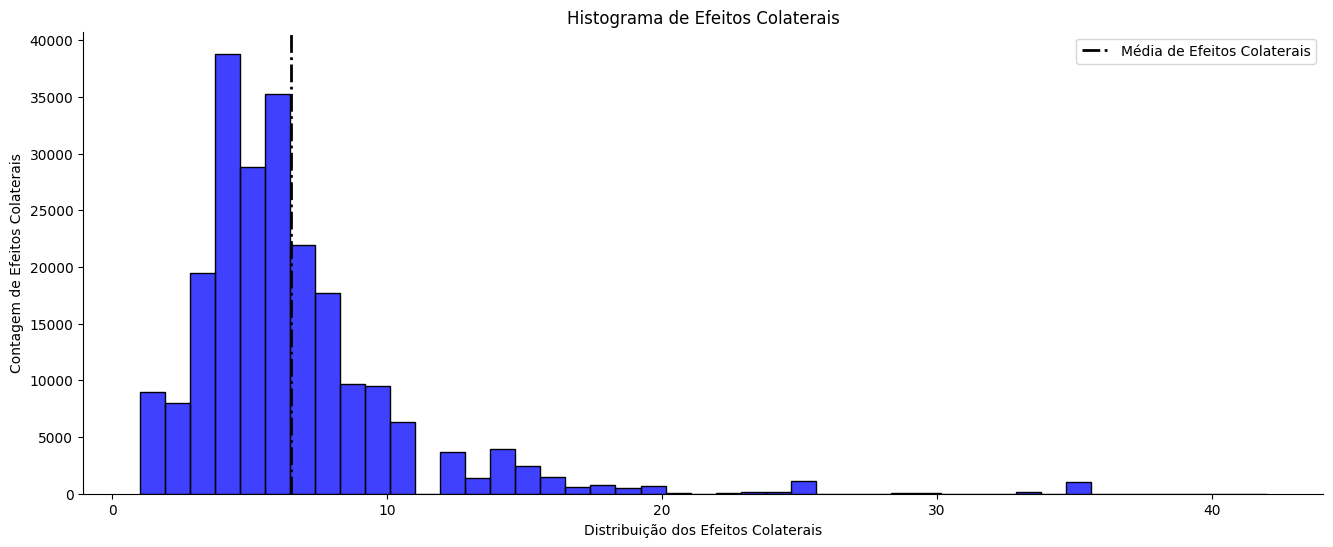

In [9]:
sns.histplot(dados, x="n_effects", kde=False, bins=45, color="blue").set_title("Histograma de Efeitos Colaterais")
plt.axvline(dados["n_effects"].mean(), color="black", linestyle="-.", linewidth=2.0, label = "Média de Efeitos Colaterais")
plt.xlabel("Distribuição dos Efeitos Colaterais")
plt.ylabel("Contagem de Efeitos Colaterais")
sns.despine(top=True, right=True)
plt.legend(loc="upper right")
plt.show()

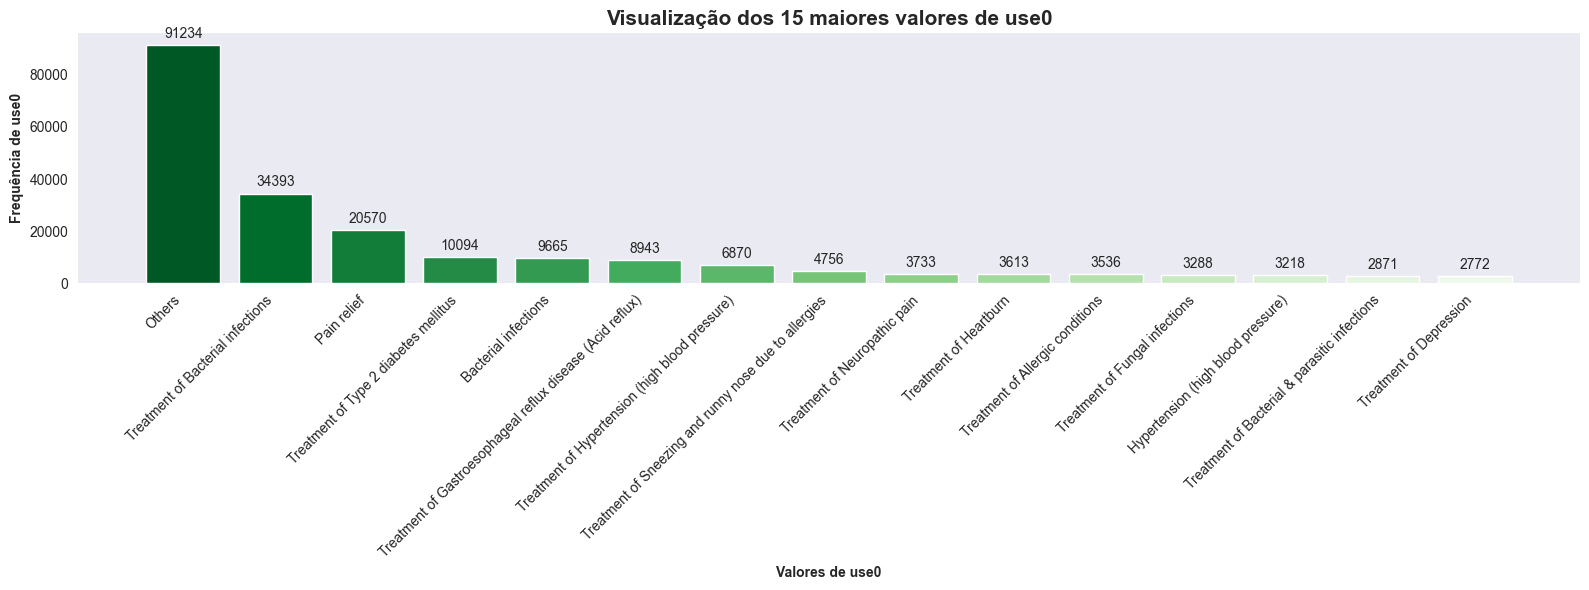

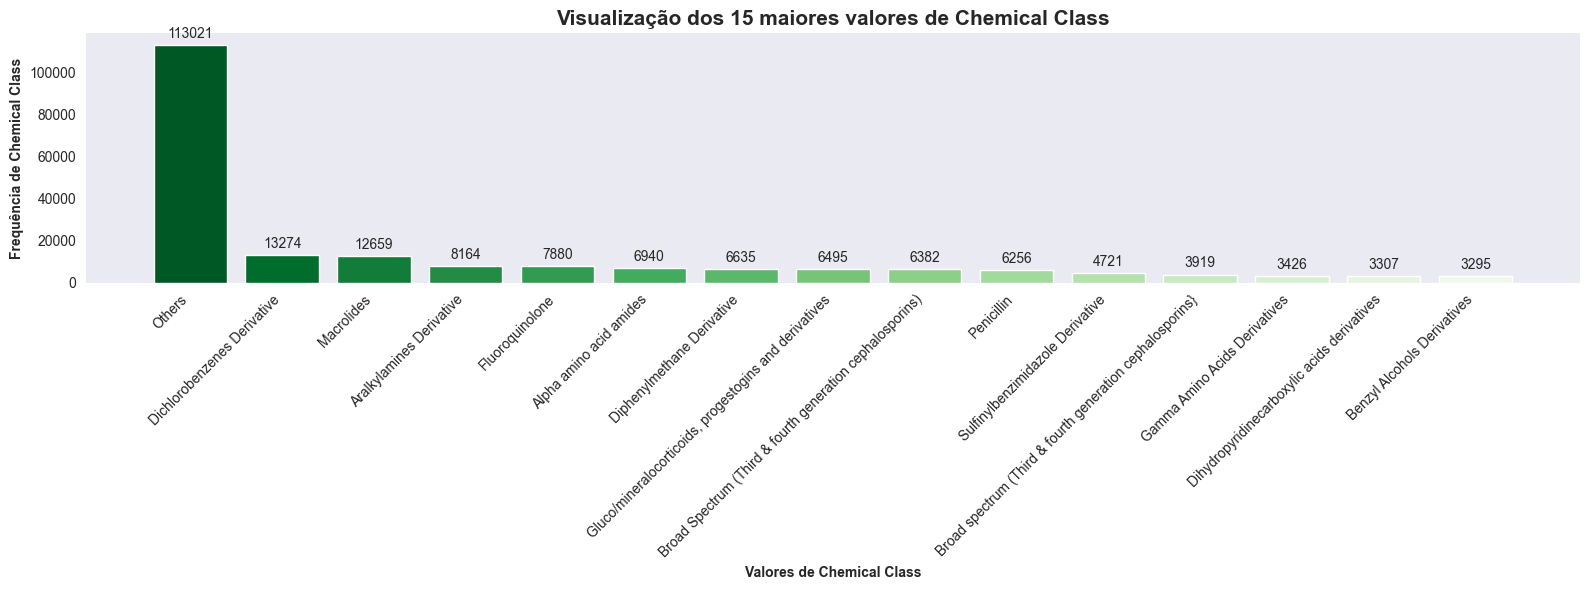

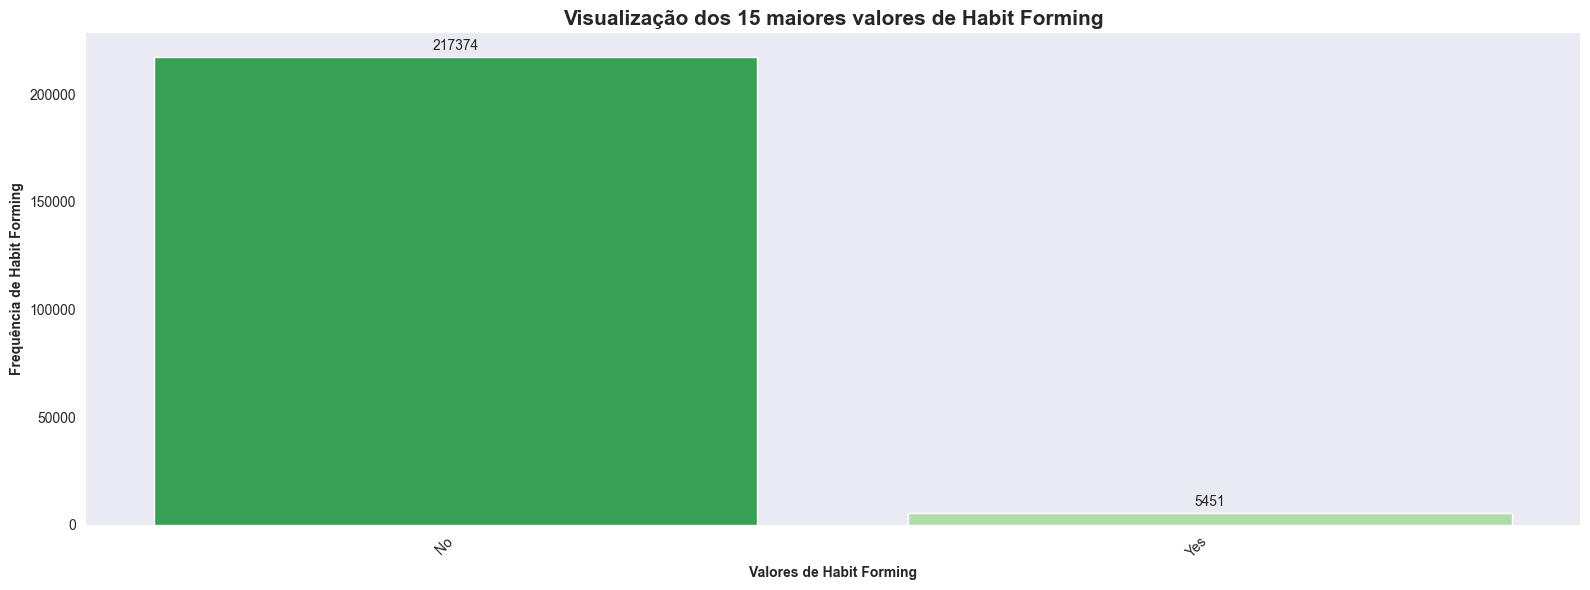

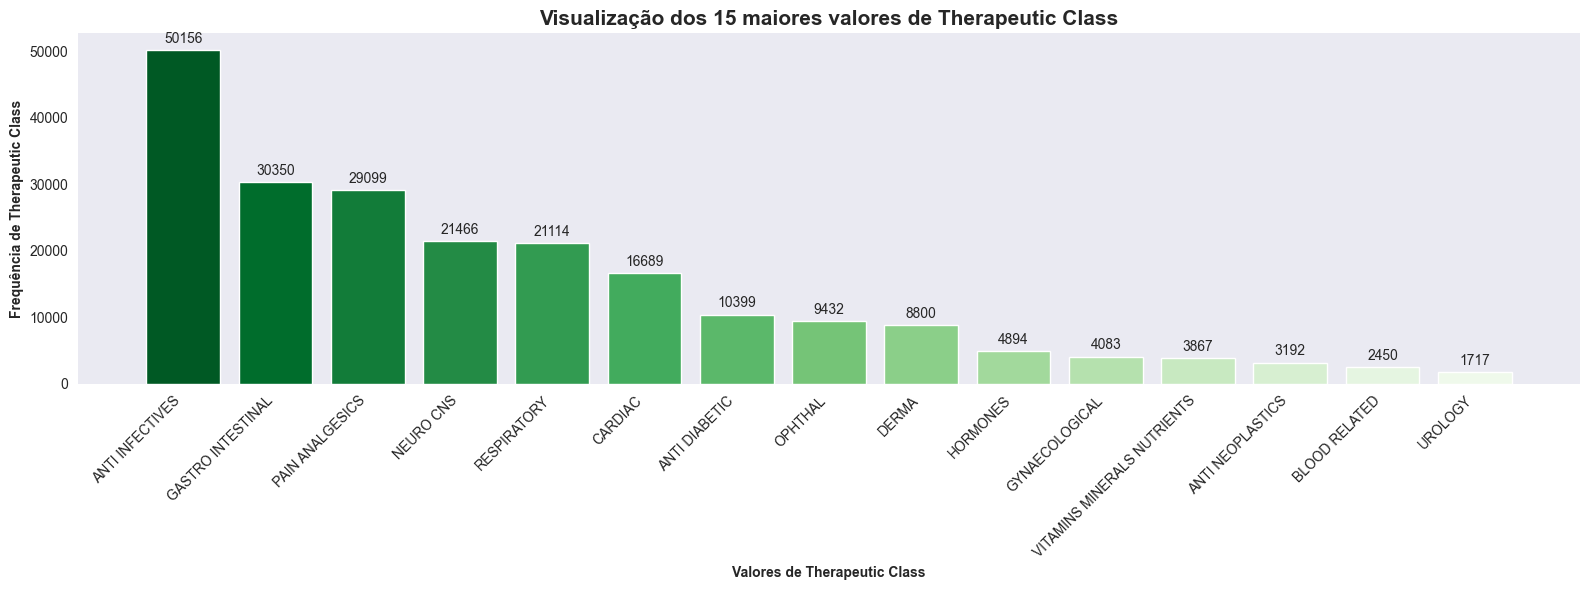

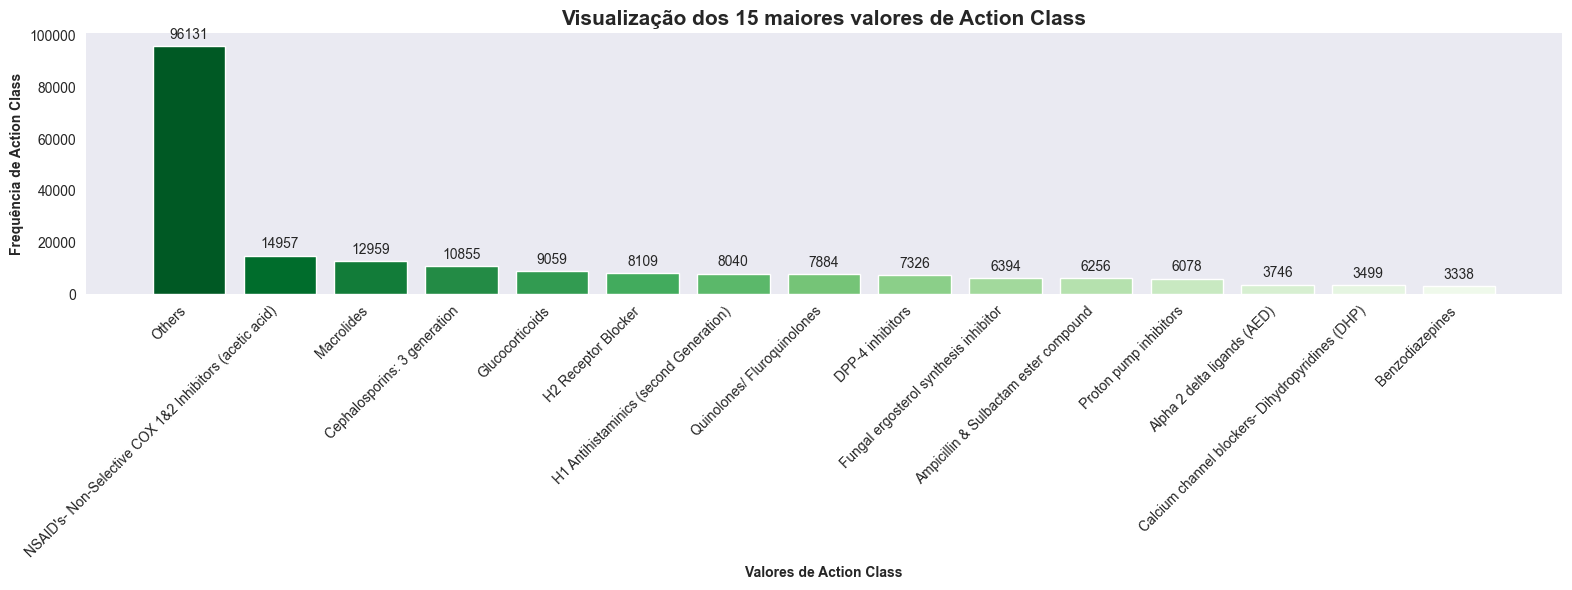

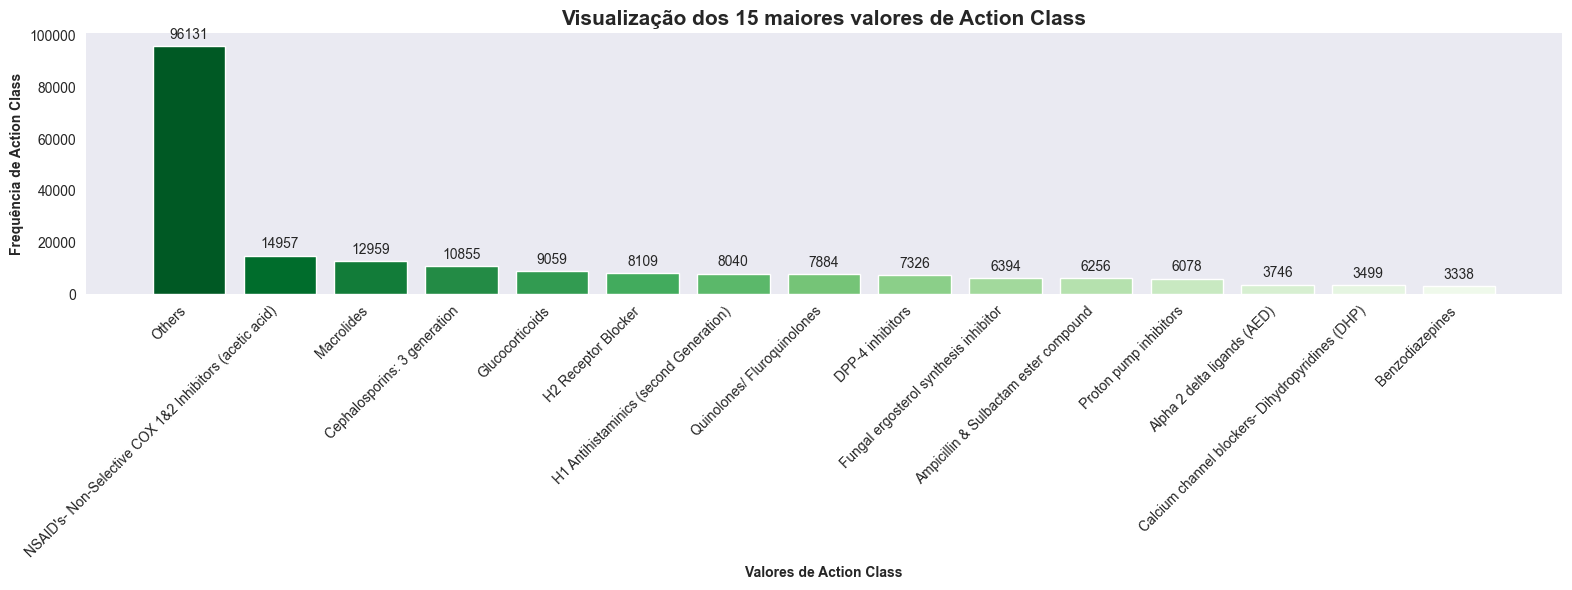

In [39]:
plot_barras(dados, "Greens_r", 15)

In [11]:
print(dados.head())

                                                use0  \
0                  Treatment of Bacterial infections   
1                  Treatment of Bacterial infections   
2                      Treatment of Cough with mucus   
3  Treatment of Sneezing and runny nose due to al...   
4                   Treatment of Allergic conditions   

                 Chemical Class Habit Forming Therapeutic Class  \
0                    Macrolides            No   ANTI INFECTIVES   
1                    Macrolides            No   ANTI INFECTIVES   
2  Phenylmethylamine Derivative            No       RESPIRATORY   
3    Diphenylmethane Derivative            No       RESPIRATORY   
4         Pyridines Derivatives            No       RESPIRATORY   

                             Action Class  n_effects  dosage  
0                              Macrolides          3     625  
1                              Macrolides          4     500  
2                              Mucolytics         14       0  
3  H1 An

In [12]:
if dados['dosage'].isnull().any():
    raise Exception("Existem valores nulos em 'dosage'.Tratar antes de prosseguir.")
quartis = dados["dosage"].quantile([0.5, 0.75, 0.9])
quartis

0.50     20.0
0.75    200.0
0.90    500.0
Name: dosage, dtype: float64

In [13]:
# Define os intervalos; Aqui usaremos os quartis
# 0 significa sem dosagem, até 50%; baixa, até 75%; média, até 90%; alta e acima disso; muito alta
bins = [0, 0.01, quartis[0.5], quartis[0.75] , quartis[0.9], dados['dosage'].max()]
labels = ['Sem dosagem', 'Baixa(até 20mg)', "Média(até 200mg)", "Alta(até 500mg)", 'Muito alta(apartir de 500mg)'] # Transformar a coluna "dosage" em categórica usando pd.cut
dados['dosage_categ'] = pd.cut(dados['dosage'], bins=bins, labels=labels, include_lowest=True) #Nova coluna dosagem categórica, para visualização

# Calcular a média dos efeitos adversos para servir de referência
media_effects = dados['n_effects'].mean()

# Criar uma coluna para identificar os casos de "alto risco":
# definido aqui como medicamentos com n_effects acima da média e com habit forming = "Yes"
dados['HighRisks'] = ((dados['n_effects'] > media_effects) & (dados['Habit Forming'] == "Yes")).astype(int)
dados['HighRisks'].describe()

count    222825.000000
mean          0.014217
std           0.118386
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: HighRisks, dtype: float64

In [14]:
dados["dosage_categ"].value_counts()

dosage_categ
Média(até 200mg)                67247
Sem dosagem                     64068
Baixa(até 20mg)                 49139
Alta(até 500mg)                 31413
Muito alta(apartir de 500mg)    10958
Name: count, dtype: int64

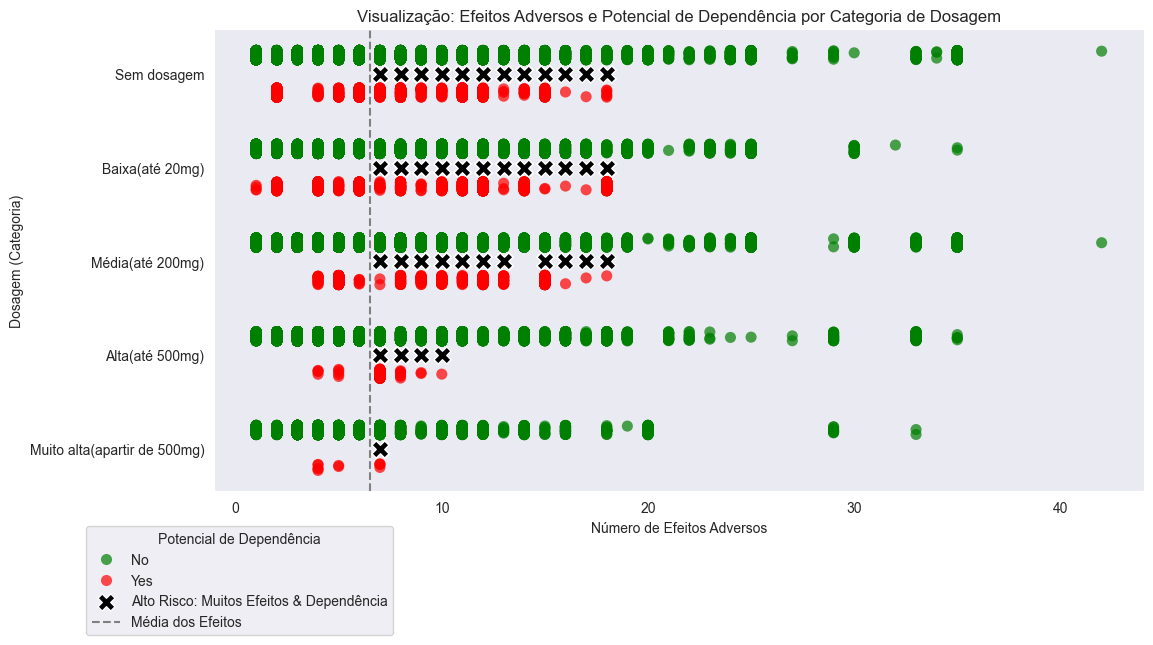

In [15]:
# Configurar a figura para a visualização
plt.figure(figsize=(12, 6))

# Gerar o strip plot: 
# - Eixo X: Número de Efeitos Adversos ("n_effects")
# - Eixo Y: Categoria de Dosagem ("dosage_categ")
# - Cores diferenciadas pela variável "Habit forming"
sns.stripplot(
    data=dados, 
    x="n_effects", 
    y="dosage_categ", 
    jitter=True, 
    hue="Habit Forming", 
    dodge=True, 
    palette={"Yes": "red", "No": "green"}, 
    size=8, 
    alpha=0.7
)

# Overlay: destacar os pontos de alto risco com um marcador especial (X em preto)
high_risk_df = dados[dados['HighRisks'] == 1]
sns.scatterplot(
    data=high_risk_df, 
    x="n_effects", 
    y="dosage_categ", 
    marker="X", 
    color="black", 
    s=150, 
    label="Alto Risco: Muitos Efeitos & Dependência"
)

# Adicionar uma linha vertical indicando a média dos efeitos adversos
plt.axvline(media_effects, color="gray", linestyle="--", label="Média dos Efeitos")

# Configuração dos eixos, título, legenda e rótulos
plt.xlabel("Número de Efeitos Adversos")
plt.ylabel("Dosagem (Categoria)")
plt.title("Visualização: Efeitos Adversos e Potencial de Dependência por Categoria de Dosagem")
plt.legend(title="Potencial de Dependência", bbox_to_anchor=(0.2, -0.06))
plt.show()


***Note que de uma maneira geral, os medicamentos de maior risco estão concentrados de 5 até 18 efeitos colaterais. Esses medicamentos merecem uma atenção maior quanto ao risco associado ao seu uso***

- ***Monitoramento de Dosagens Altas e Médias***
- + > *Medicamentos com dosagens médias (até 200mg) e altas (até 500mg) apresentam maior risco de dependência e efeitos adversos. Isso sugere a necessidade de ajustes nas formulações ou estratégias de mitigação de riscos.*

- ***Oportunidades em Baixas Dosagens:***

- + > *As categorias de baixa dosagem (até 20mg) e sem dosagem também mostram uma incidência de dependência e efeitos adversos considerável. Isso pode refletir medicamentos psicotrópicos de baixa dosagem ou sem dosagem associada*

- ***Análise de Medicamentos com Dosagem Muito Alta:***
- > *Apesar de alguns medicamentos com dosagem muito alta (a partir de 500mg) não apresentarem dependência, há casos de alto risco que exigem atenção especial. Investigar esses casos pode ajudar a melhorar a segurança.*

- ***Foco na Média dos Efeitos Adversos:***
- > *Medicamentos acima da média dos efeitos adversos, indicada pela linha tracejada no gráfico, devem ser priorizados para revisão e otimização.*

- ***Altas Dosagens, baixa dependência***
- > *Medicamentos com dosagens muito altas (apartir de 500mg) parecem ter baixas ocorrências de dependência. O que pode refletir os riscos associados a vitaminas de alta dosagem, como vitamina D.*
  > *Nessa categoria também estão algumas penicilinas injetáveis, por exemplo, que tem dosagens altíssimas e podem refletir as poucas ocorrências de muitos efeitos adversos, necessitando também de determinada atenção*
  

## Tratamento final dos dados

In [16]:
dados.head()

,use0,Chemical Class,Habit Forming,Therapeutic Class,Action Class,n_effects,dosage,dosage_categ,HighRisks
0,Treatment of Bacterial infections,Macrolides,No,ANTI INFECTIVES,Macrolides,3,625,Muito alta(apartir de 500mg),0
1,Treatment of Bacterial infections,Macrolides,No,ANTI INFECTIVES,Macrolides,4,500,Alta(até 500mg),0
2,Treatment of Cough with mucus,Phenylmethylamine Derivative,No,RESPIRATORY,Mucolytics,14,0,Sem dosagem,0
3,Treatment of Sneezing and runny nose due to al...,Diphenylmethane Derivative,No,RESPIRATORY,H1 Antihistaminics (second Generation),4,120,Média(até 200mg),0
4,Treatment of Allergic conditions,Pyridines Derivatives,No,RESPIRATORY,H1 Antihistaminics (First Generation),2,25,Média(até 200mg),0


In [17]:
dados.dtypes

use0                   object
Chemical Class         object
Habit Forming          object
Therapeutic Class      object
Action Class           object
n_effects               int64
dosage                  int64
dosage_categ         category
HighRisks               int32
dtype: object

In [18]:
# Selecionar colunas relevantes para as features. Usamos todas as categóricas e variáveis numéricas de interesse.
# Definir as colunas categóricas para tratamento
categorical_columns = ["Action Class", "Chemical Class", "Habit Forming", "Therapeutic Class", "use0"]

# Limitar os valores únicos para cada coluna categórica (segundo nossa distribuição escolhemos 20)
limit = 20
for col in categorical_columns:
    dados = limit_unique_values(dados, col, limit)

dados.head(n=7)

,use0,Chemical Class,Habit Forming,Therapeutic Class,Action Class,n_effects,dosage,dosage_categ,HighRisks
0,Treatment of Bacterial infections,Macrolides,No,ANTI INFECTIVES,Macrolides,3,625,Muito alta(apartir de 500mg),0
1,Treatment of Bacterial infections,Macrolides,No,ANTI INFECTIVES,Macrolides,4,500,Alta(até 500mg),0
2,Others,Others,No,RESPIRATORY,Others,14,0,Sem dosagem,0
3,Treatment of Sneezing and runny nose due to al...,Diphenylmethane Derivative,No,RESPIRATORY,H1 Antihistaminics (second Generation),4,120,Média(até 200mg),0
4,Treatment of Allergic conditions,Others,No,RESPIRATORY,Others,2,25,Média(até 200mg),0
5,Treatment of Sneezing and runny nose due to al...,Diphenylmethane Derivative,No,RESPIRATORY,H1 Antihistaminics (second Generation),8,0,Sem dosagem,0
6,Treatment of Bacterial infections,Macrolides,No,ANTI INFECTIVES,Macrolides,3,625,Muito alta(apartir de 500mg),0


In [19]:
for coluna in dados.columns:
    unicos = dados[coluna].nunique()
    print("Coluna: {} - Valores Únicos: {} ".format(coluna, unicos))

Coluna: use0 - Valores Únicos: 21 
Coluna: Chemical Class - Valores Únicos: 21 
Coluna: Habit Forming - Valores Únicos: 2 
Coluna: Therapeutic Class - Valores Únicos: 21 
Coluna: Action Class - Valores Únicos: 21 
Coluna: n_effects - Valores Únicos: 33 
Coluna: dosage - Valores Únicos: 218 
Coluna: dosage_categ - Valores Únicos: 5 
Coluna: HighRisks - Valores Únicos: 2 


In [20]:
# A variável HighRisk será 1 se:
# - n_effects for maior que a média da coluna.
dados['HighRisk'] = (dados['n_effects'] > dados['n_effects'].mean()).astype(int) #Criação da variável alvo : HighRisk

# Separar as variáveis de entrada (X) e a variável alvo (y)
numerical_cols = ['dosage']
feature_cols = categorical_columns + numerical_cols

X = dados[feature_cols]
y = dados['HighRisk']
y[:10]

0    0
1    0
2    1
3    0
4    0
5    1
6    0
7    0
8    0
9    0
Name: HighRisk, dtype: int32

In [21]:
y.value_counts()

HighRisk
0    139240
1     83585
Name: count, dtype: int64

In [22]:
dados

,use0,Chemical Class,Habit Forming,Therapeutic Class,Action Class,n_effects,dosage,dosage_categ,HighRisks,HighRisk
0,Treatment of Bacterial infections,Macrolides,No,ANTI INFECTIVES,Macrolides,3,625,Muito alta(apartir de 500mg),0,0
1,Treatment of Bacterial infections,Macrolides,No,ANTI INFECTIVES,Macrolides,4,500,Alta(até 500mg),0,0
2,Others,Others,No,RESPIRATORY,Others,14,0,Sem dosagem,0,1
3,Treatment of Sneezing and runny nose due to al...,Diphenylmethane Derivative,No,RESPIRATORY,H1 Antihistaminics (second Generation),4,120,Média(até 200mg),0,0
4,Treatment of Allergic conditions,Others,No,RESPIRATORY,Others,2,25,Média(até 200mg),0,0
...,...,...,...,...,...,...,...,...,...,...
222820,Treatment of Bacterial infections,Broad Spectrum (Third & fourth generation ceph...,No,ANTI INFECTIVES,Cephalosporins: 3 generation,3,100,Média(até 200mg),0,0
222821,Treatment of Hypertension (high blood pressure),Others,No,CARDIAC,Others,8,30,Média(até 200mg),0,1
222822,Others,Others,No,RESPIRATORY,Others,5,25,Média(até 200mg),0,0
222823,Treatment of Bacterial infections,Macrolides,No,ANTI INFECTIVES,Macrolides,5,500,Alta(até 500mg),0,0


In [23]:
# Remover as colunas numéricas originais do X (se houver duplicidade) e adicionar as variáveis numéricas escalonadas
X = X.drop(columns=numerical_cols, errors='ignore')

In [24]:
# Escalonamento das variáveis numéricas
scaler = StandardScaler()
X_numeric = scaler.fit_transform(dados[numerical_cols])
dump(scaler, 'objects/scaler.joblib') # Salvar o scaler para uso posterior
X_numeric = pd.DataFrame(X_numeric, columns=numerical_cols, index=X.index)
X_final = pd.concat([X, X_numeric], axis=1)

# Divisão dos dados em conjuntos de treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
X_train

,Action Class,Chemical Class,Habit Forming,Therapeutic Class,use0,dosage
116967,H1 Antihistaminics (second Generation),Diphenylmethane Derivative,No,RESPIRATORY,Treatment of Sneezing and runny nose due to al...,-0.027253
95751,Others,Others,No,ANTI INFECTIVES,Bacterial infections,-0.011448
206072,Alpha 2 delta ligands (AED),Gamma Amino Acids Derivatives,No,NEURO CNS,Treatment of Neuropathic pain,-0.027253
32779,Cephalosporins: 3 generation,Broad spectrum (Third & fourth generation ceph...,No,ANTI INFECTIVES,Treatment of Bacterial infections,-0.020931
222695,Cephalosporins: 3 generation,Broad Spectrum (Third & fourth generation ceph...,No,ANTI INFECTIVES,Treatment of Bacterial infections,-0.024092
...,...,...,...,...,...,...
154397,Others,Others,No,GYNAECOLOGICAL,Others,-0.027253
169269,Others,Others,No,NEURO CNS,Treatment of Depression,-0.025672
218015,Others,Others,No,RESPIRATORY,Others,-0.025672
114734,Fungal ergosterol synthesis inhibitor,Others,No,DERMA,Others,-0.027253


In [26]:
# Codificação de variáveis categóricas: transformar as colunas categóricas numéricas
encoder = LabelEncoder()
for cols in X[categorical_columns]:
    X_train[cols] = encoder.fit_transform(X_train[cols])
    X_test[cols] = encoder.transform(X_test[cols])
    dump(encoder, f"objects/encoder_{cols}.joblib") # Salvar o encoder para uso posterior


In [28]:
dados.drop(["dosage_categ", "n_effects", "HighRisks"], axis=1, inplace=True) #Apagar a coluna criada para visualização dos efeitos colaterais e outras não necessárias
dados.to_csv("medicamentos_final.csv", index=False) #Salvar o conjunto de dados final

## Criação dos Modelos

In [29]:
# Treinamento de um modelo de classificação (Regressão Logística)
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# 10. Predições e avaliação do modelo
y_pred = model.predict(X_test)
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.65      0.88      0.75     27848
           1       0.52      0.21      0.30     16717

    accuracy                           0.63     44565
   macro avg       0.58      0.55      0.52     44565
weighted avg       0.60      0.63      0.58     44565

0.5458112585885483


In [30]:
confusion_matrix(y_test, y_pred)

array([[24634,  3214],
       [13256,  3461]], dtype=int64)

In [31]:
# --- Definição dos Modelos ---
models = {
    "RandomForest": RandomForestClassifier(random_state=42, n_estimators=100),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42, n_estimators=100)
    
}

# --- Treinamento e Avaliação de Cada Modelo ---
model_results = {}

for name, model in models.items(): 
    print(f"Treinando o modelo: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    model_results[name] = {"model": model, "report": report, "accuracy": acc, "Roc-Auc": roc}
    
    
    print(f"Relatório de Classificação para {name}:")
    print(report)
    print("Acurácia:", acc)
    print("Roc-Auc:", roc)
    print("-"*75)

Treinando o modelo: RandomForest
Relatório de Classificação para RandomForest:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     27848
           1       0.85      0.76      0.80     16717

    accuracy                           0.86     44565
   macro avg       0.86      0.84      0.85     44565
weighted avg       0.86      0.86      0.86     44565

Acurácia: 0.8583417480085269
Roc-Auc: 0.8389757549408485
---------------------------------------------------------------------------
Treinando o modelo: XGBoost
Relatório de Classificação para XGBoost:
              precision    recall  f1-score   support

           0       0.85      0.92      0.89     27848
           1       0.85      0.73      0.79     16717

    accuracy                           0.85     44565
   macro avg       0.85      0.83      0.84     44565
weighted avg       0.85      0.85      0.85     44565

Acurácia: 0.851722203522944
Roc-Auc: 0.8280124453624343
---------

**Há uma diferença bem pequena entre o desempenho do RandomForest e do XGBoost e talvez essa diferença não seja estatisticamente significativa.**
- **Porém, como os dois são relativamente parecidos em relação ao custo computacional, usaremos o RandomForest que obteve um desempenho ligeiramente melhor que o XGBoost**.

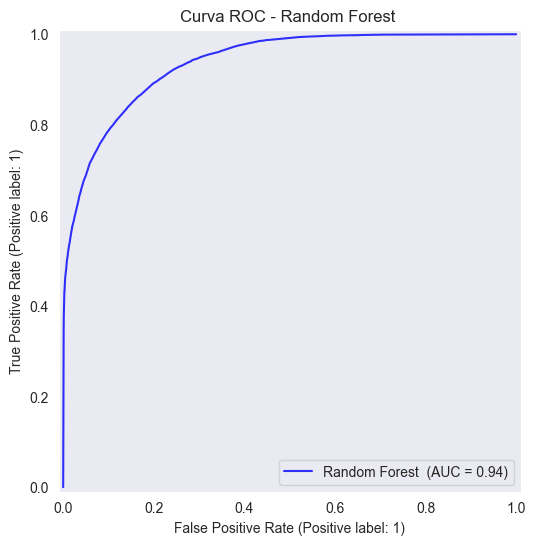

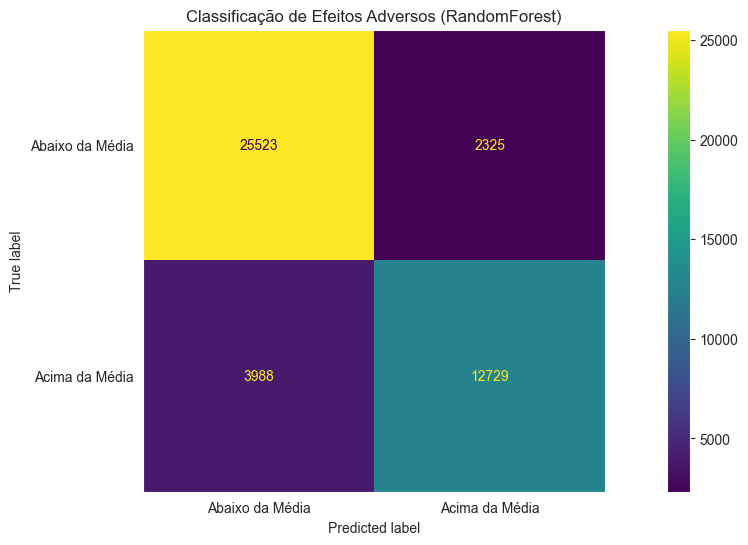

In [43]:
RocCurveDisplay.from_estimator(
    models["RandomForest"], X_test, y_test, name="Random Forest ", color="blue", alpha=0.8)
plt.title("Curva ROC - Random Forest ")
plt.show()
ConfusionMatrixDisplay.from_estimator(models["RandomForest"], X_test, y_test, display_labels=["Abaixo da Média", "Acima da Média"])
plt.title("Previsão de Efeitos Adversos (RandomForest)")
plt.show()

- **A curva ROC está bem próxima da borda superior (1.0) o que é um ótimo indicativo quanto à generalização do Modelo.**
+ **A matriz de confusão mostra isso de forma mais abrangente em relação aos acertos e erros do modelo, indicando a confiabilidade das previsões.**

## Explicabilidades

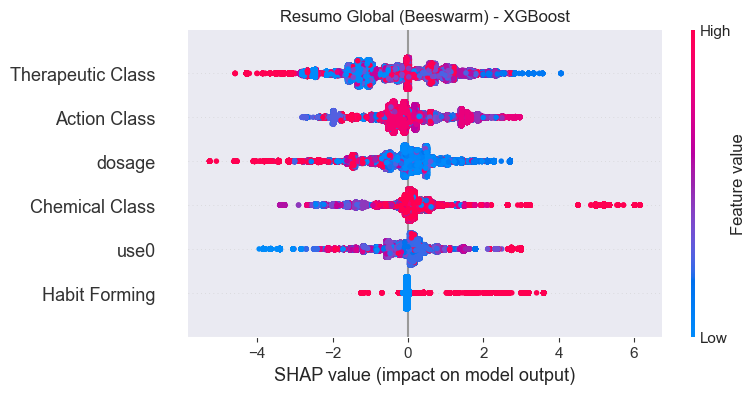

In [34]:
# --- Explicabilidade Global com SHAP para Modelos Trees ---
# Usaremos o TreeExplainer, que se adapta muito bem aos modelos baseados em árvores.

# Checagem com XGBoost:
model_xgb = models["XGBoost"]
explainer_xgb = shap.TreeExplainer(model_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_train)

# Gráfico global - Beeswarm Plot para visualizar a importância e o impacto das features:
shap.summary_plot(shap_values_xgb, X_train, plot_type="dot", show=False)
plt.title("Resumo Global (Beeswarm) - XGBoost")
plt.show()

***Algumas Interpretações***
- **Acima, podemos ver como cada variável contribui para as decisões do modelo - Pontos vermelhos significam alto valor da variável, azul significa baixo e roxo médio**
- Por exemplo, altas dosagens 'puxam muito' as previsões para 'efeitos abaixo da média' e baixas dosagens 'puxam porém menos' para acima da média. E isso é um caso a ser investigado.
- Classe química também tem pontos com FORTES influências nas decisões. Classe química mais alta significa "EFEITOS ACIMA DA MÉDIA"
- Potencial de Dependência positivo (vermelho) significa "EFEITOS ACIMA DA MÉDIA" enquanto negativo fica em 0, ou seja não tem influência sobre a previsão

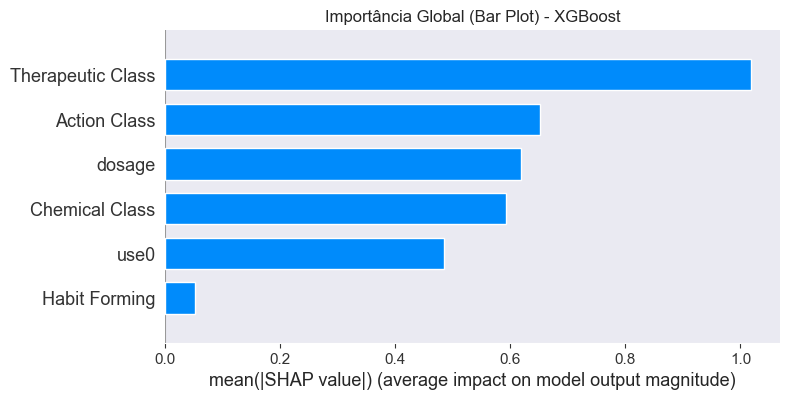

In [35]:
# Gráfico global - Bar Plot para importância média das features:
shap.summary_plot(shap_values_xgb, X_train, plot_type="bar", show=False)
plt.title("Importância Global (Bar Plot) - XGBoost")
plt.show()


***Aqui podemos ver as variáveis mais importantes.***
- **Essas exercem grande impacto nas decisões do modelo, com destaque para:**

- > Classe Terapêutica. Impacto próximo de 1.0, ou seja, altíssimo.
  > Classe de Ação, dosagem e Classe química. Bem menor que classe terapêutica, mas ainda assim bastante influentes (~ 0.6).

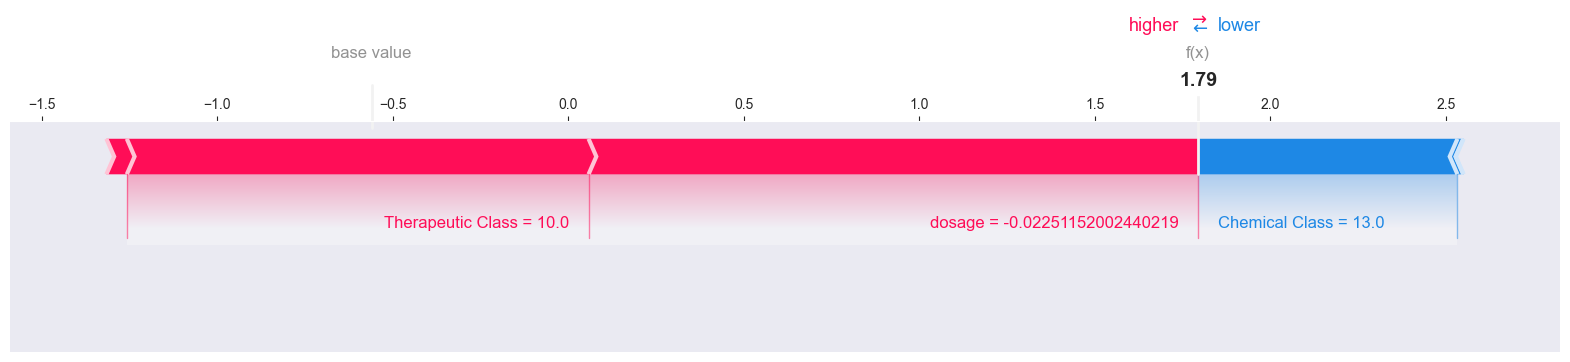

In [36]:
# --- Explicabilidade Local com SHAP ---
# Escolher uma instância para análise local (escolha aleatória com numpy)
instance_index = np.random.randint(X_test.shape[0])
X_instance = X_test.iloc[[instance_index]]

# Calcular os valores SHAP para a instância selecionada (usaremos o mesmo explainer do modelo XGBoost)
shap_value_instance = explainer_xgb.shap_values(X_instance)

# Inicializar visualizações interativas, se necessário:
shap.initjs()

# Gerar o Force Plot para a explicação local
force_plot = shap.force_plot(
    explainer_xgb.expected_value, shap_value_instance, 
    X_instance, matplotlib=True, show=False
)
plt.show()

***Aqui, a interpretação de um medicamento selecionado aleatoriamente.***
- *Podemos ver a contribuição massiva que Classe terapêutica e dosagem tiveram nessa previsão*
- Elas puxaram a previsão para um valor mais alto indicando "Maior ocorrência de Efeitos Colaterais"
- Em contra partida, a classe química influenciou a previsão negativamente, porém essa influência não foi suficiente para ultrapassar a influência positiva das outra variáveis.
- Portanto, nesse caso a classificação final foi positiva. Ou seja, o medicamento provavelmente apresenta um número de efeitos colaterais acima da média.

In [37]:
# Salvar o modelo otimizado (RandomForest)
dump(models["RandomForest"], 'objects/best_model.joblib')

['objects/best_model.joblib']